# ResNet-50 Training – ODIR-5K

## Objective
This notebook trains a **ResNet-50** convolutional neural network for **multi-label ocular disease classification** using the ODIR-5K dataset.

The notebook is fully self-contained and:
- Uses ImageNet-pretrained ResNet-50
- Applies Binary Cross-Entropy loss
- Trains on GPU (CUDA) if available
- Displays progress bars during training
- Plots training vs validation accuracy and loss

## Section 1 - Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 2050


In [4]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
IMAGE_ROOT = DATA_DIR / "ODIR-5K" / "ODIR-5K"

train_df = pd.read_csv(PROCESSED_DIR / "train.csv")
val_df = pd.read_csv(PROCESSED_DIR / "val.csv")

label_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
NUM_CLASSES = len(label_cols)

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))

Train samples: 5600
Val samples: 1400


## Section 2 - Image Transforms

ImageNet normalization is used because the model is pretrained.

In [5]:
# Transforms
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

## Section 3 - Custom PyTorch Dataset

In [6]:
# Dataset Definition
class ODIRDataset(Dataset):
    def __init__(self, dataframe, image_root, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_root = image_root
        self.transform = transform

        self.image_names = self.df["image_name"].values
        self.labels = self.df[label_cols].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.image_root / "Training Images" / self.image_names[idx]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        labels = torch.from_numpy(self.labels[idx])
        return image, labels

## DataLoaders

In [7]:
# DataLoaders
BATCH_SIZE = 16
NUM_WORKERS = 0 

train_dataset = ODIRDataset(train_df, IMAGE_ROOT, train_transforms)
val_dataset = ODIRDataset(val_df, IMAGE_ROOT, val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

print("DataLoaders ready.")

DataLoaders ready.


## Section 4 - ResNet-50 Model

In [8]:
# Model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

print(model.fc)

Linear(in_features=2048, out_features=8, bias=True)


## Loss Function & Optimizer

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),weight_decay=1e-4)

## Multi-Label Accuracy Function

In [10]:
def multilabel_accuracy(outputs, targets, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs >= threshold).float()
    return (preds == targets).float().mean().item()

## Section 5 - Training & Validation Loop

In [11]:
EPOCHS = 10

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += multilabel_accuracy(outputs, labels)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += multilabel_accuracy(outputs, labels)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )


Epoch 1/10


Validation: 100%|██████████| 88/88 [01:55<00:00,  1.31s/it]


Train Loss: 0.3580 | Train Acc: 0.8515 | Val Loss: 0.3491 | Val Acc: 0.8533

Epoch 2/10


Validation: 100%|██████████| 88/88 [03:01<00:00,  2.06s/it]


Train Loss: 0.3501 | Train Acc: 0.8527 | Val Loss: 0.3840 | Val Acc: 0.8412

Epoch 3/10


Validation: 100%|██████████| 88/88 [03:03<00:00,  2.09s/it]


Train Loss: 0.3444 | Train Acc: 0.8531 | Val Loss: 0.3450 | Val Acc: 0.8526

Epoch 4/10


Validation: 100%|██████████| 88/88 [03:02<00:00,  2.07s/it]


Train Loss: 0.3405 | Train Acc: 0.8533 | Val Loss: 0.3744 | Val Acc: 0.8438

Epoch 5/10


Validation: 100%|██████████| 88/88 [03:05<00:00,  2.11s/it]


Train Loss: 0.3369 | Train Acc: 0.8535 | Val Loss: 0.3377 | Val Acc: 0.8534

Epoch 6/10


Validation: 100%|██████████| 88/88 [01:59<00:00,  1.35s/it]


Train Loss: 0.3340 | Train Acc: 0.8540 | Val Loss: 0.3336 | Val Acc: 0.8547

Epoch 7/10


Validation: 100%|██████████| 88/88 [01:57<00:00,  1.34s/it]


Train Loss: 0.3296 | Train Acc: 0.8548 | Val Loss: 0.3250 | Val Acc: 0.8551

Epoch 8/10


Validation: 100%|██████████| 88/88 [01:56<00:00,  1.32s/it]


Train Loss: 0.3261 | Train Acc: 0.8550 | Val Loss: 0.3323 | Val Acc: 0.8542

Epoch 9/10


Validation: 100%|██████████| 88/88 [02:38<00:00,  1.80s/it]


Train Loss: 0.3249 | Train Acc: 0.8557 | Val Loss: 0.3326 | Val Acc: 0.8533

Epoch 10/10


Validation: 100%|██████████| 88/88 [02:37<00:00,  1.79s/it]

Train Loss: 0.3233 | Train Acc: 0.8560 | Val Loss: 0.3276 | Val Acc: 0.8544


## Section 6 - Save Trained Model

In [12]:
checkpoint_dir = PROJECT_ROOT / "checkpoints" / "resnet50"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), checkpoint_dir / "resnet50_odir.pth")
print("Model saved.")

Model saved.


## Save Training History

We save the training and validation metrics to disk so they can be loaded later for model comparison.

In [13]:
import json
from pathlib import Path

# Create results directory
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

In [14]:
history = {
    "train_accuracy": train_acc_hist,
    "val_accuracy": val_acc_hist,
    "train_loss": train_loss_hist,
    "val_loss": val_loss_hist
}

with open(RESULTS_DIR / "resnet50_history.json", "w") as f:
    json.dump(history, f, indent=4)

print("ResNet-50 training history saved.")

ResNet-50 training history saved.


## Section 7 - Training & Validation Curves

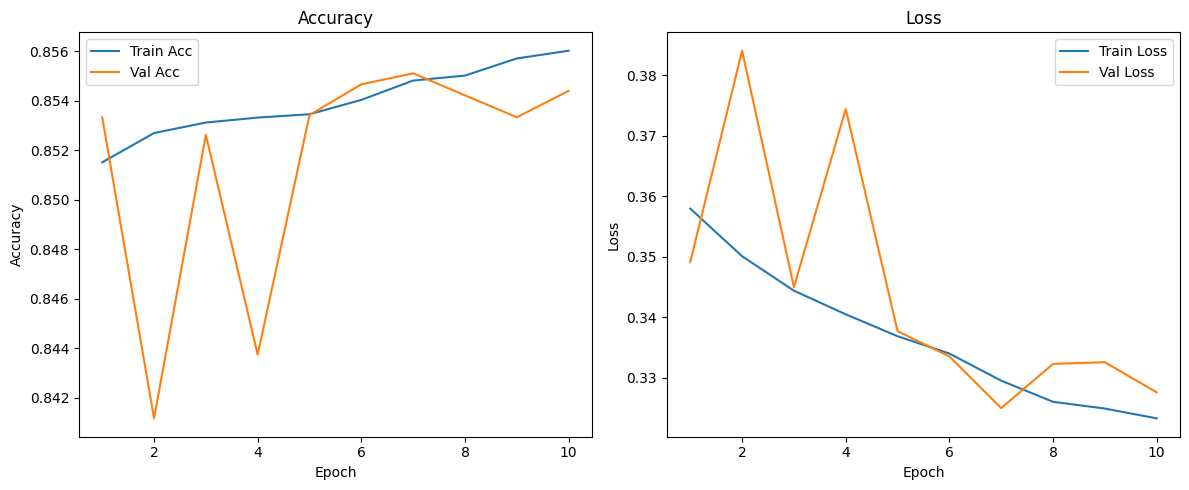

In [15]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_hist, label="Train Acc")
plt.plot(epochs, val_acc_hist, label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_hist, label="Train Loss")
plt.plot(epochs, val_loss_hist, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()